## Embedding Projection for Graphics Classifier(T-SNE, PCA, Umap)
+ In this notebook we use different projection for the last layer prior to the softmax layer in the CNN
+ Source:
    + Chart_Synthetic : Synthetic dataset of graphic images
    + Chart2020       : Dataset for infographics 2020
    + clef16          : Clef challenge 2016
    + clef13          : Clef challenge 2013


## 1. Importing Libraries

In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from utils.FeatureExtractor import get_vector_representation,prepare_projection
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset,EvalImageDataset
from utils.ModelPrediction import get_prediction
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass
# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# 4. Wandb Tracker Experiements
import wandb

## 2. Feature Extraction - ResNet CNN

In [2]:
DATA_PATH = '../data/graphics_dataset_final_v1.csv'
BASE_PATH = Path('/mnt')
BASE_IMG_DIR = BASE_PATH
SEED = 42
model_path = '/mnt/artifacts/models/Graphics/graphics_classifier_v1.pt'

In [3]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder,dict_label = label_encoder_target(df,target_col='higher_modality')
df.head()

,img,original,modality,source,img_path,higher_modality,split_set,target
0,100050.png,Scatter,scatterplot,Chart_Synthetic,chart_synthetic_1/train/100050.png,GRAPHICS,TRAIN,scatterplot
1,0.png,Grouped horizontal bar,histogram,Chart_Synthetic,chart_synthetic_1/train/0.png,GRAPHICS,TRAIN,histogram
2,1.png,Grouped horizontal bar,histogram,Chart_Synthetic,chart_synthetic_1/train/1.png,GRAPHICS,TRAIN,histogram
3,100052.png,Scatter,scatterplot,Chart_Synthetic,chart_synthetic_1/train/100052.png,GRAPHICS,TRAIN,scatterplot
4,10.png,Grouped vertical bar,histogram,Chart_Synthetic,chart_synthetic_1/train/10.png,GRAPHICS,VAL,histogram


In [ ]:
# 3.1 Load the Resnet Model
model = ResNetClass.load_from_checkpoint(model_path)
print('*'*5,' Resnet Model Parameters ','*'*5)
print(model.hparams)
print('*'*5,' Resnet Model Children ','*'*5)
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

In [ ]:
%%time
prepare_projection(model ,le_encoder,DATA_PATH,BASE_IMG_DIR,SEED,CLASSF ='graphics' ,VERSION = 1)

In [ ]:
df_projection = pd.read_parquet( '/mnt/artifacts/projections/graphics_v1.parquet')
plt.figure(figsize=(8,8))
df1 = df_projection[df_projection['split_set']=='TRAIN'].reset_index(drop = True)
sns.scatterplot(data=df1, x="pca_x", y="pca_y", hue="modality")
plt.show()

### 2.1 Evaluation on GFIG Images (Different From Training or Vallidation Dataset)

In [16]:
# Dataloader for the GFIG IMAGES
df_gfig = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t')
df_gfig = df_gfig[df_gfig['modality'].isin(['GFIG'])].reset_index(drop = True)
df_gfig.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,1297-9686-42-10-3-1.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1297-9686-42-10-3-1.jpg,GRAPHICS,Accuracy of QTL-EBV and total EBV as a functio...,TRAIN
1,1297-9686-42-10-3-2.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1297-9686-42-10-3-2.jpg,GRAPHICS,Accuracy of QTL-EBV and total EBV as a functio...,TRAIN
2,1297-9686-42-10-3-3.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1297-9686-42-10-3-3.jpg,GRAPHICS,Accuracy of QTL-EBV and total EBV as a functio...,TRAIN
3,1297-9686-42-10-3-4.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1297-9686-42-10-3-4.jpg,GRAPHICS,Accuracy of QTL-EBV and total EBV as a functio...,TRAIN
4,1423-0127-16-6-3-2.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1423-0127-16-6-3-2.jpg,GRAPHICS,Kinetic analysis of human EndoG . (A) Electrop...,TRAIN


In [17]:
test_transform = [transforms.ToPILImage(),
                 transforms.Resize((224, 224)),
                 transforms.ToTensor(),
                 transforms.Normalize(resnet_model.hparams['mean_dataset'], resnet_model.hparams['std_dataset'])
                ]
test_transform = transforms.Compose(test_transform)

test_dataset   = EvalImageDataset(df_gfig,
                                  BASE_IMG_DIR/'subfigure-classification',
                                  image_transform=test_transform,
                                  path_col='img_path')

test_dataloader = torch.utils.data.DataLoader(
                    test_dataset,
                    batch_size = 32,
                    shuffle = False,
                    num_workers = 72
                    )

In [18]:
model = resnet_model.to('cuda')
test_predictions = get_prediction(test_dataloader,model, 'cuda')
df_gfig ['Graphics_Classifier_Class_Predicted'] = le_encoder_graphics.inverse_transform(test_predictions)

In [19]:
# Get the Embedding Matrix
# 1. Tranformations Needed
transform = [transforms.ToPILImage(),
             transforms.Resize((224, 224)),
             transforms.ToTensor(),
             transforms.Normalize(resnet_model.hparams['mean_dataset'], resnet_model.hparams['std_dataset'])
            ]
transform = transforms.Compose(transform)
# 2. Train Dataloader
dm = ImageDataModule    ( batch_size  = 32,
                          label_encoder    = le_encoder_graphics,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [transform,transform,transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path',
                          shuffle_train    = False) # Not Shuffling Train
dm.prepare_data()
dm.setup()

# 3. Model
FE = ResNetFeatureExtractor(parts_resnet[1]).to('cuda')
train_dataloader = dm.train_dataloader()
fe_matrix        = get_vector_representation(train_dataloader,FE,'cuda')

## 3.Embedding Projection

## 3.1 Umap 

### 3.1.1 Train Set

In [21]:
%%time
reducer = umap.UMAP(random_state=42)
reducer.fit(fe_matrix)

CPU times: user 8min 58s, sys: 12min 24s, total: 21min 22s
Wall time: 8min 35s


UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=42)

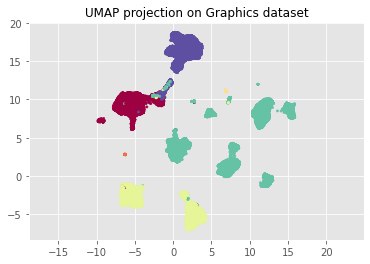

In [27]:
embedding = reducer.transform(fe_matrix)
plt.scatter(embedding[:, 0], embedding[:, 1], c=le_encoder_graphics.transform(df[df['split_set']=='TRAIN'].reset_index(drop = True).modality), cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection on Graphics dataset', fontsize=12);

In [29]:
#fe_model = ResNetFeatureExtractor(parts_resnet[1]).to('cuda')
#fe_matrix_gfig = get_vector_representation(test_dataloader,fe_model,'cuda')